# Solving the Max Independent Set Problem

In this notebook, we will describe how to solve the **Max Independent Set** with LunaSolve. We will begin by defining, explaining and giving an example for the Max Independent Set problem. We will then continue by modeling a problem instance, optimize it and implement the solution using LunaSolve. Finally, we will also take a further look at the interpretation of the answer we are returned from Luna.


## Table of Contents

1. [Introduction](#1)
2. [A Real World Example](#2)
3. [Solving the Max Independent Set problem with Luna](#3)



<a id="1"></a>
## 1. Introduction

## Max Independent Set

The Max Independent Set problem is a fundamental challenge in graph theory. It asks us to find the largest possible group of nodes in a graph such that no two nodes in the group are connected by an edge, in other words, a subset of nodes that are completely disconnected from each other.

Formally, let $ G = (V, E) $ be an undirected graph. An *independent set* is a subset of vertices $ S \subseteq V $ such that for every pair of distinct vertices $ u, v \in S $, the edge $ (u, v) \notin E $. The Max Independent Set problem then asks us to find the largest such subset $ S $.

<a id="2"></a>
## 2. A Real-World Example

To bring this idea into a practical context, imagine managing a library with several study rooms. Some rooms are located close enough that noise from one room can disturb another. The goal is to select the largest number of rooms that can be used at the same time without any potential for noise interference.

Consider six study rooms labeled A, B, C, D, E, and F. The following constraints define which rooms interfere with one another:

- A and B cannot be used at the same time.
- A and C cannot be used at the same time.
- B and D cannot be used at the same time.
- C and D cannot be used at the same time.
- D and E cannot be used at the same time.
- E and F cannot be used at the same time.

We can represent this scenario with a graph where each room is a node, and an edge connects any pair of rooms that interfere with each other. Solving the Max Independent Set problem on this graph will give us the largest group of study rooms that can be used simultaneously without causing disturbances.

<a id="3"></a>
## 3. Solving the Max Independent Set problem with Luna

To follow along with the next steps, you'll need the following three libraries:
1. **luna-quantum** for modeling and solving our optimization problem,
2. **matplotlib** for visualizing the results, and
3. **networkx** for creating and displaying the graphs.

Run the cell below to install these libraries automatically if they aren't already installed.

In [ ]:
# Install the python packages that are needed for the notebook
%pip install --upgrade pip
%pip install luna-quantum --upgrade
%pip install matplotlib networkx

### 3.1 Setting Up the Luna Client

Now let's dive into solving the Max Independant Set problem using LunaSolve. First, you'll instantiate a LunaSolve object and configure your credentials. The API key identifies your account and grants access to Luna's services. You can find your API key in your Aqarios account settings.

In [2]:
from luna_quantum import LunaSolve
import getpass
import os

if "LUNA_API_KEY" not in os.environ:
    # Prompt securely for the key if not already set
    os.environ["LUNA_API_KEY"] = getpass.getpass("Enter your Luna API key: ")

ls = LunaSolve()

In [ ]:
from luna_quantum import Logging
import logging

Logging.set_level(logging.WARNING)

If you haven't yet configured a QPU token for your account, or if you'd like to add a new one, you can do so using the `ls.qpu_token.create()` method. However, in this tutorial we will be using a classical solver from Dwave, which does not require one.

### 3.2 Create a Max Independent Set problem

To create a `MaxIndependentSet` instance, any graph with vertices and edges is sufficient. In this notebook, we’ll represent the relationships between the study rooms through a graph. The study rooms are represented as the nodes of the graph. Any time two rooms are close enough to disturb each other, we’ll draw an edge between them.

After defining the graph, we will visualize it for better comprehension.

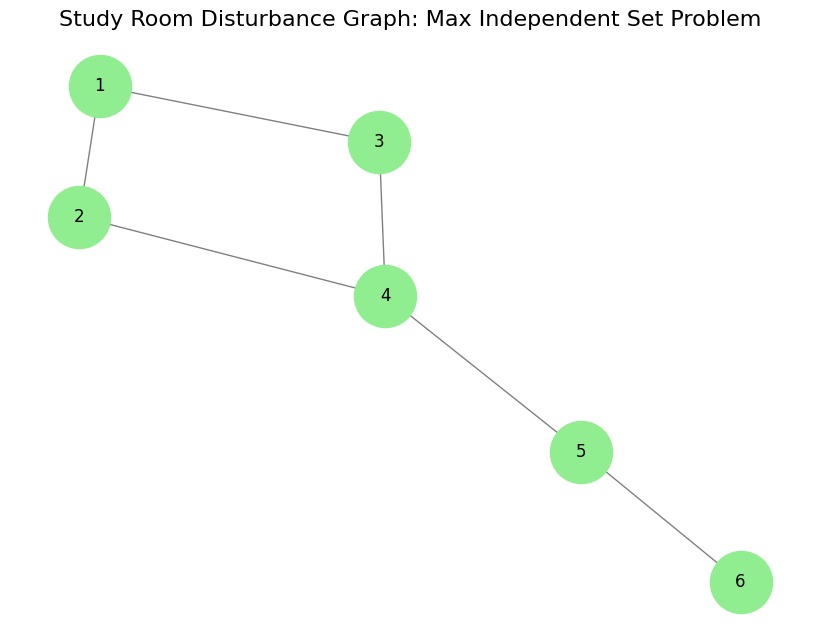

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Create the graph
max_independent_set_graph = nx.Graph()

# Add nodes to the graph (which represent the different study rooms)
rooms = [1, 2, 3, 4, 5, 6]
max_independent_set_graph.add_nodes_from(rooms)

# Add edges to the graph (which represent the realtive noice disturbance between the rooms)
disturbances = [
    (1, 2),
    (1, 3),
    (2, 4),
    (3, 4),
    (4, 5),
    (5, 6)
]
max_independent_set_graph.add_edges_from(disturbances)

# Draw the graph using maplotlib
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(max_independent_set_graph)
nx.draw(
    max_independent_set_graph, pos, with_labels=True, node_size=2000, font_size=12, 
    node_color="lightgreen", font_color="black", edge_color="gray"
)
plt.title("Study Room Disturbance Graph", fontsize=16)
plt.show()

### 3.3 Defining a Max Independent Set Object
To find the largest independent set using LunaSolve, we define the Max Independent Set use case using Luna’s `MaxIndependentSet` class. This class converts the problem instance into an optimization problem, which Luna can then optimize.

For a correct initialization of the `MaxIndependentSet` class, the graph must be given in the form of a dictionary using netwrokx's `nx.to_dict_of_dicts()` method. Additionally, the instance can also be given a `name`, which is set on default to `MIS` for Max Independant Set.

In [5]:
# import the MaxIndependentSet object from the luna sdk
from luna_quantum.solve.use_cases import MaxIndependentSet

# create a MaxIndependentSet object
max_independent_set = MaxIndependentSet(graph=nx.to_dict_of_dicts(max_independent_set_graph))


### 3.4 Creating a Luna Optimization

Now, let's upload our Max Independant Set problem to Luna. We can use LunaSolve's `ls.model.create_from_use_case()` method and provide the use case object we just defined and assign a clear, identifiable `name` to the optimization.

In [6]:
# Create and upload a model using the created use case instance
model = ls.model.create_from_use_case(name="Max Independant Set", use_case=max_independent_set)

### 3.5 Choose an Algorithm and Run It

The final step is to create a job request, sending our optimization task to the hardware provider to solve. To successfully create a job, we must first select an algorithm for the optimization from LunaSolve's collection, specify the algorithm's parameters and select a backend for the algorithm to run on.

In this instance, we solve the Max Independant Set problem using simulated annealing (sa) and choose D-Wave (dwave) as the hardware provider. Simulated annealing has multiple parameters which can be adjusted to fine-tune the exact optimization. Here we are going to set the `num_reads` equal to 1000. This means that the annealing process is done 1000 times, returning 1000 sampled results.

Lastly, we execute the job by calling the `algorithm.run()` method and passing the `model` together with a chosen `name` for the job for easy identification.

In [7]:
from luna_quantum.solve.parameters.algorithms import SimulatedAnnealing
from luna_quantum.solve.parameters.backends import DWave

#Select the SimulatedAnnealingSolver algorithm.
algorithm = SimulatedAnnealing(
    backend=DWave(),
    num_reads=1000, 
)

# Execute an outbound solve request.
job = algorithm.run(model.id, name="MIS with SA")

### 3.6 Retrieving the Solution

In step 3.4, we uploaded our problem, and in step 3.5, we sent a solution request to Luna. Luna automatically manages the subsequent background processes. This includes preparing the optimization problem, converting it into the correct format for the quantum hardware provider, submitting the problem to the quantum computer, and finally retrieving and translating the solution back into a user-friendly format.

Now let's discuss the final stages: retrieving the solution, converting it back to our original problem representation, and interpreting the results.

First, we'll use the `job.result()` method to fetch our results. The returned `Solution` object contains several attributes related to the optimization, including metadata such as the `runtime`, the `count` (how often each sample occurred), the `objective_value` and `raw_energies` of each sample. To learn more about the `Solution` Object visit Luna's thorough documentation.

In [ ]:
solution = job.result()

The `Solution` object returns the sampled solutions in the native optimization format of the provider's solver together with its metadata. To interpret the solutions quicker, LunaSolve provides automatic post-processing functions which decode the samples back into an intuitive and easy-to-read format as below.

You can use the `job.get_use_case_representation_result()` method to retrieve the decoded form of the solution. This returns the solution in a readable format, with a few key components:

- The `sense` attribute indicates whether our objective is to maximize or minimize the target function.
- The `result` is typically an iterable containing the `representation` (the solution itself) and the corresponding `obj_value` (objective value). While the objective value can be complex due to embedded constraint penalties, generally, smaller values signify better solutions for minimization problems and vice versa for maximization problems.
- The `description` helps clarify the format of the returned `representation`.

In the case of the Max Independent Set problem, the `representation` is a list which contains the indices of all nodes that are included in the maximally independent set. In other words, the representation is a list of all indices $i$, for which their subset decision variable $x_i$ is equal to one.

****

### 🔍 Upcoming Feature: Use Case Representation Analysis

*Coming soon to the Luna SDK!*

We're introducing a powerful new capability: Use Case Representation Analysis. This feature will allow you to analyze and visualize how your use cases are interpreted across models and workflows—giving you deeper insight into solution quality, representation alignment, and more.

✨ **What to Expect**   
You'll soon be able to retrieve and examine the full use case representation for a given solve job:

In [ ]:
use_case_result = ls.solve_job.get_use_case_representation(job.id)
print(use_case_result)

Finally, if we wish to only see the best solution from all evaluated samples we can call the `job.get_use_case_representation_best_result()` method.

In [14]:
best_use_case_result = ls.solve_job.get_best_use_case_result(use_case_result)
print(best_use_case_result)

representation=[0, 1, 5] obj_value=-3.0


In order to better grasp the solution, we can visualize the maximally independent set using the graph we created, and colour all nodes which have a value of 0 red and all others that are 1, green.

In [ ]:
# Colour the nodes based on the best result, Green nodes are indlucede in the MIS and red nodes are not
colours = ["green" if node in best_use_case_result["solution"] else "red" for node in max_independent_set_graph.nodes]

# Draw the graph with new coloring
plt.figure(figsize=(8, 6))
nx.draw(max_independent_set_graph, pos, with_labels=True, node_color=colours, edge_color="gray", node_size=1000, font_size=12)
plt.title("Coloured MIS Network")
plt.show()

Congrats! You have now solved the Set Partitioning problem using the use case library of Luna! If you are interested in finding out more about the plethora of different use cases Luna provides, we encourage you to explore the use case library!